In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot as plt

In [2]:
a = pd.read_csv('train.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2,3,4,6,7,8,10,11,12,15,16,19,23,26,30,36,37,39,49,52,56,58,59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Checking for missing values

In [3]:
pd.isna(a).sum().sum()

0

In [4]:
a.describe()

,id,forecasting period,class
count,25121.000000,25121.000000,25121.000000
mean,12560.000000,2.608574,0.044823
std,7251.952392,1.063099,0.206919
min,0.000000,1.000000,0.000000
25%,6280.000000,2.000000,0.000000
50%,12560.000000,3.000000,0.000000
75%,18840.000000,4.000000,0.000000
max,25120.000000,4.000000,1.000000


In [5]:
a.dtypes

id                                              int64
forecasting period                              int64
net_profit_over_total_assets                   object
total_liabilities_over_total_assets            object
working_capital_over_total_assets              object
                                                ...  
sales_over_receivables                         object
short_term_liabilities_times_365_over_sales    object
sales_over_short_term_liabilities              object
sales_over_fixed_assets                        object
class                                           int64
Length: 67, dtype: object

Bringing data into numerical form

In [6]:
a = a.apply(pd.to_numeric, errors='coerce',downcast='integer')

In [7]:
a.describe()

,id,forecasting period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,...,sales_minus_cost_of_products_sold_over_sales,current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_minus_depreciation,total_costs_overtotal_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets,class
count,25121.000000,25121.000000,25118.000000,25118.000000,25118.000000,25043.000000,2.506400e+04,25118.000000,25118.000000,25072.000000,...,25044.000000,25118.000000,25068.000000,25118.000000,2.383900e+04,25064.000000,2.504400e+04,25043.000000,24630.000000,25121.000000
mean,12560.000000,2.608574,0.046883,0.611913,0.098553,6.285753,-9.125936e+01,-0.067728,0.147535,15.153162,...,-0.770713,0.098693,4.429418,1.597135,3.225273e+02,14.315634,7.394522e+02,9.835042,77.756289,0.044823
std,7251.952392,1.063099,1.821696,5.933447,5.908136,339.973627,1.828476e+04,6.873121,5.835287,611.473437,...,72.977149,10.380960,383.343937,152.441163,1.606698e+04,120.835222,5.627363e+04,154.676272,2694.281611,0.206919
min,0.000000,1.000000,-256.889998,-72.162006,-479.959994,-0.044851,-1.670200e+06,-508.409992,-189.559992,-141.410220,...,-8534.599415,-979.250019,-1.631820,-327.970143,-4.066151e-02,-12.655400,-2.336500e+06,-0.367905,-10677.001615,0.000000
25%,6280.000000,2.000000,0.003354,0.271005,0.016605,1.037774,-5.058748e+01,-0.000010,0.005649,0.422289,...,0.008843,0.015141,0.875577,-0.000002,5.620743e+00,4.538417,4.158029e+01,3.100047,2.185147,0.000000
50%,12560.000000,3.000000,0.049864,0.476965,0.191679,1.553757,-1.702077e+00,0.000003,0.060077,1.051214,...,0.052831,0.122515,0.950947,0.005193,9.973974e+00,6.732840,7.090939e+01,5.116548,4.340603,0.000000
75%,18840.000000,4.000000,0.131419,0.693583,0.401751,2.767430,5.120627e+01,0.085018,0.153186,2.593104,...,0.129194,0.293705,0.993072,0.241881,2.082144e+01,10.601720,1.169599e+02,8.708598,9.892896,0.000000
max,25120.000000,4.000000,52.651999,480.960001,22.769001,53433.000440,1.034100e+06,322.199997,649.230003,53431.999474,...,293.158392,552.639985,59671.999668,23853.000122,2.137800e+06,12296.000520,7.276000e+06,23453.999855,294769.993913,1.000000


Looking at the balance between categories (bankruptcy, no bankruptcy)

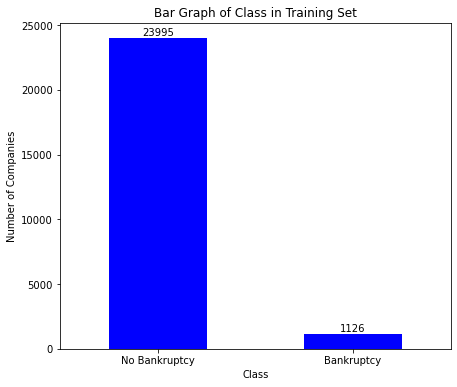

In [8]:
class_graph = a['class'].value_counts()
plt.figure(figsize=(7, 6))
ax = class_graph.plot(kind='bar', rot=0, color="b")
ax.set_title("Bar Graph of Class in Training Set", y = 1)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Companies')
ax.set_xticklabels(('No Bankruptcy', 'Bankruptcy'))

for i in ax.patches:
    y_value = i.get_height()
    x_value = i.get_x() + i.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

Splitting the data into train and testing

In [9]:
X, y = a.iloc[:,1:66], a.iloc[:,66]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=211)

Algorith parameters

In [11]:
paramGrid = {
    'max_depth':[2,3,4,5],
    'alpha':[0.5,0.7,1,1.2],
    'subsample':[1],
    'learning_rate':[0.15, 0.2, 0.25],
    'n_estimators':[180,200,220,250],
    'colsample_bytree':[1],
    'colsample_bylevel':[1],
    'scale_pos_weight':[1,21,22],
    'objective':['binary:logistic'],
    'eval_metric':['logloss']
}

Defining the algorith

In [12]:
xgb_clf = xgb.XGBClassifier(tree_method='gpu_hist',gpu_id=0)

Creating cross-validation folds that keep the ratio between the 2 classes

In [13]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=211)

Looking for the best algorith parameters

In [14]:
xgb_rs = GridSearchCV(estimator=xgb_clf, param_grid=paramGrid, cv=cv, verbose=1, scoring='f1')

Fitting the train data to the model

In [15]:
xgb_rs.fit(X_train,y_train)

Fitting 15 folds for each of 576 candidates, totalling 8640 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=211),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=0, grow_policy=None,
                                     importance_type=None,
                                     interac...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'alpha': [0.5, 0.7, 1, 1.2], 'colsample_bylevel': [1],
                         'colsample_bytree': [1], 'eval_metric': ['logloss'],
                         'learn

In [16]:
print("Best parameters found:", xgb_rs.best_params_)

Best parameters found: {'alpha': 1.2, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'eval_metric': 'logloss', 'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 220, 'objective': 'binary:logistic', 'scale_pos_weight': 22, 'subsample': 1}


In [17]:
print("Best accuracy found:",xgb_rs.best_score_)

Best accuracy found: 0.7170110984310772


In [18]:
best = xgb_rs.best_estimator_

In [19]:
print(best)

XGBClassifier(alpha=1.2, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=220,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1.20000005, ...)


Searching for best threshold

In [20]:
# predict probabilities
yhat = xgb_rs.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.242534, F-Score=0.758


In [21]:
best_thres = thresholds[ix]
print(best_thres)

0.24253361


Prediction using the best thershold that was found

In [22]:
preds = (xgb_rs.predict_proba(X_test)[:,1]>=best_thres).astype(int)

In [23]:
print(accuracy_score(y_test,preds))

0.9799655035159878


In [24]:
print(f1_score(y_test, preds))

0.7584000000000001


Testing the model on the test dataset

In [25]:
b = pd.read_csv('test.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (2,3,4,7,8,10,11,15,19,23,26,30,36,37,39,49,52,58,60) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
b = b.apply(pd.to_numeric, errors='coerce',downcast='integer')

In [27]:
b.dtypes

id                                               int32
forecasting period                                int8
net_profit_over_total_assets                   float64
total_liabilities_over_total_assets            float64
working_capital_over_total_assets              float64
                                                ...   
sales_over_inventory                           float64
sales_over_receivables                         float64
short_term_liabilities_times_365_over_sales    float64
sales_over_short_term_liabilities              float64
sales_over_fixed_assets                        float64
Length: 66, dtype: object

In [28]:
b2 = b.iloc[:,1:66]

In [29]:
preds_test = (xgb_rs.predict_proba(b2)[:,1]>=best_thres).astype(int)

In [30]:
b['class'] = preds_test

In [31]:
final = b[['id','class']]

In [32]:
final.head()

,id,class
0,25121,0
1,25122,0
2,25123,0
3,25124,0
4,25125,0


In [33]:
final.to_csv('sub_repeatedStratifiedKFold.csv',index=False)